In [1]:
import os
import struct
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Load_mnist(path, sort='train'):
    #从‘path’路径导入MNIST数据集
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % sort)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % sort)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


#调用函数，读取数据
training_images, training_labels = Load_mnist(os.getcwd(), 'train')
test_images, test_labels = Load_mnist(os.getcwd(), 't10k')
training_num = 60000
test_num = 10000
training_images = torch.tensor(training_images)
training_labels = torch.tensor(training_labels)
test_images = torch.tensor(test_images)
test_labels = torch.tensor(test_labels)

test_images = test_images / 255.0
training_images = training_images / 255.0

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #两层卷积、池化网络
        self.conv1 = nn.Conv2d(1, 3, 4)  # N,1,28,28——N,3,25,25
        self.mp1 = nn.MaxPool2d(2)  #——N,3,12,12

        self.conv2 = nn.Conv2d(3, 12, 4)  # ——N,12,9,9
        self.mp2 = nn.MaxPool2d(2)  # ——N,12,4,4
        # 全连接层
        self.fc1 = nn.Linear(12 * 4 * 4, 16)
        #         self.fc2 = nn.Linear(96, 64)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)

        x = x.float()
        #非线性激活函数为ReLU
        x = F.relu(self.conv1(x))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        #         x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def Processing_test_data():
    #测试数据集，计算错误率
    prediction = model(test_images)
    loss_ = criterion(prediction, test_labels.long())
    prediction = torch.argmax(prediction, dim=1)  #整理预测出的值

    error = 0
    for i in range(test_num):
        if test_labels[i].item() != prediction[i].item():
            error += 1

    return loss_.item(), error / test_num


def Get_training_error(pred):
    pred = torch.argmax(pred, dim=1)
    error = 0
    for i in range(training_num):
        if training_labels[i].item() != pred[i].item():
            error += 1
    return error / training_num

0 2.308030843734741 0.902


KeyboardInterrupt: 

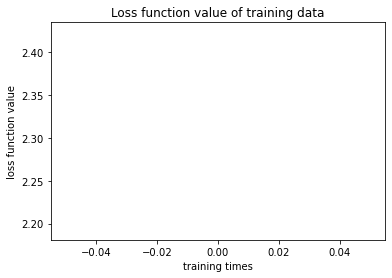

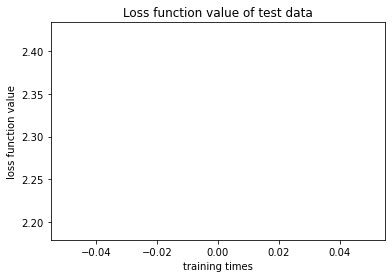

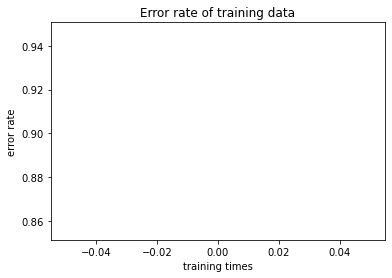

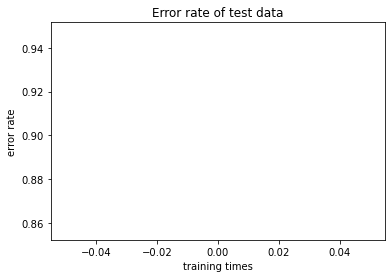

In [5]:
error_rate1, error_rate2 = [], []
episodes = []
loss_value1 = []
loss_value2 = []
avg_length = 10

model = Model()
criterion = nn.CrossEntropyLoss()  #采用交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)  #使用SGD优化器

for e in range(6000):  #训练数据集，调整参数
    optimizer.zero_grad()  #零梯度缓冲
    output = model(training_images)
    loss = criterion(output, training_labels.long())  #计算损失函数

    loss.backward()
    #更改学习率
    if e == 15:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.145)
    elif e == 42:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.065)
    elif e == 55:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.025)
    elif e == 275:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.0112)
    optimizer.step()  #更新
    #作图
    if e % avg_length == 0:  #每十次记一回数
        episodes.append(e)

        loss_value1.append(loss.item())
        error_rate1.append(Get_training_error(output))

        value2, rate2 = Processing_test_data()
        loss_value2.append(value2)
        error_rate2.append(rate2)

        plt.figure(1)
        plt.title("Loss function value of training data")
        plt.xlabel("training times")
        plt.ylabel("loss function value")
        plt.plot(episodes, loss_value1, 'r')

        plt.figure(2)
        plt.title("Loss function value of test data")
        plt.xlabel("training times")
        plt.ylabel("loss function value")
        plt.plot(episodes, loss_value2, 'b')

        plt.figure(3)
        plt.title("Error rate of training data")
        plt.xlabel("training times")
        plt.ylabel("error rate")
        plt.plot(episodes, error_rate1, 'c')

        plt.figure(4)
        plt.title("Error rate of test data")
        plt.xlabel("training times")
        plt.ylabel("error rate")
        plt.plot(episodes, error_rate2, 'g')
        plt.savefig('4.jpg')

    print(e, loss.item(), rate2)
    if loss.item() < 0.01:
        break